In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from haversine import haversine
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import LearningCurveDisplay
import pickle
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.cloud import bigquery

In [3]:
client = bigquery.Client()

In [4]:
query = """SELECT
  *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  pickup_latitude IS NOT NULL
  AND pickup_longitude IS NOT NULL
  AND dropoff_latitude IS NOT NULL
  AND dropoff_longitude IS NOT NULL
  AND pickup_census_tract IS NOT NULL
  AND dropoff_census_tract IS NOT NULL
  AND fare IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_start_timestamp IS NOT NULL
  AND trip_end_timestamp IS NOT NULL
  AND trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND tips IS NOT NULL
  AND tolls IS NOT NULL
  AND extras IS NOT NULL
  AND trip_total IS NOT NULL
  AND payment_type IS NOT NULL
  AND taxi_id IS NOT NULL
  AND unique_key IS NOT NULL
  AND pickup_location IS NOT NULL
  AND dropoff_location IS NOT NULL
  AND company IS NOT NULL
LIMIT 20000
"""

In [5]:
df = client.query(query).result().to_dataframe()
df

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,e4d2fed5efd4f697d0b55b8523787d363a501148,61d83eb1d34ccd8dac5bdd962bc13e2ac077b0c7ecbf1d...,2019-03-06 19:30:00+00:00,2019-03-06 19:30:00+00:00,0,0.0,17031810400,17031760801,10,76,...,0.5,3.75,Cash,Globe Taxi,41.980507,-87.826676,POINT (-87.8266761823 41.9805068217),41.982273,-87.841586,POINT (-87.8415864319 41.9822729289)
1,1eaac3a70a49eebd4aaac92828067ea66fdfbc5b,e3b1277a5bbff691880cdd9213bc7c40859eb5d924e005...,2019-03-05 08:00:00+00:00,2019-03-05 08:30:00+00:00,1320,2.9,17031071300,17031839100,7,32,...,0.0,17.00,Credit Card,Sun Taxi,41.921778,-87.641460,POINT (-87.6414597588 41.9217783562),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
2,993da388c55470dcd5296ebd0db750ab0a9d9f9b,61d83eb1d34ccd8dac5bdd962bc13e2ac077b0c7ecbf1d...,2019-03-06 19:30:00+00:00,2019-03-06 19:30:00+00:00,0,0.0,17031810400,17031810400,10,10,...,0.0,27.25,Cash,Globe Taxi,41.980507,-87.826676,POINT (-87.8266761823 41.9805068217),41.980507,-87.826676,POINT (-87.8266761823 41.9805068217)
3,f914d80b2e7690cbd0f7fc2c4aaa4081dc728de1,61d83eb1d34ccd8dac5bdd962bc13e2ac077b0c7ecbf1d...,2019-03-06 19:30:00+00:00,2019-03-06 19:30:00+00:00,0,0.0,17031810400,17031810400,10,10,...,0.0,34.69,Credit Card,Globe Taxi,41.980507,-87.826676,POINT (-87.8266761823 41.9805068217),41.980507,-87.826676,POINT (-87.8266761823 41.9805068217)
4,bd07d58f0001aaffb7275b4f773ef97ca51afa9d,a0144e27e6b11720292c08c38cc696f14e6254bbbad971...,2016-12-01 00:30:00+00:00,2016-12-01 01:15:00+00:00,2280,21.0,17031831400,17031491400,25,49,...,1.0,53.25,Cash,Taxi Affiliation Service Yellow,41.869119,-87.756068,POINT (-87.7560677045 41.86911914),41.689123,-87.616822,POINT (-87.6168216385 41.6891234369)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,b565e1da61044474ad40b74d003e270ed2c8d75b,a1562a6ba4d1219e2f5c0f084844fbb31bacdb192481cf...,2015-11-28 18:15:00+00:00,2015-11-28 18:30:00+00:00,600,0.0,17031080100,17031071400,8,7,...,1.0,13.25,Credit Card,Taxi Affiliation Services,41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),41.922083,-87.634156,POINT (-87.6341560931 41.922082541)
19996,8feb9278ecf265ac5d991d5886f9f6ffb168ae6d,a31f9699f20f0e9b7ced983889fbb1de859a232798bda1...,2016-01-20 10:30:00+00:00,2016-01-20 10:45:00+00:00,720,0.0,17031080100,17031281900,8,28,...,0.0,13.65,Credit Card,Taxi Affiliation Services,41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
19997,d2a9fab19a14418ca127aacbd11c41bcd0e2fd70,6fcbe0f3aba7b8bb4f6a16942b3127f338608c0edff16e...,2016-01-22 08:45:00+00:00,2016-01-22 09:15:00+00:00,1140,2.2,17031080100,17031281900,8,28,...,0.0,13.70,Credit Card,Taxi Affiliation Services,41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
19998,702fcdc1196c0c9620d92cc84547f5ac8f1b8408,d9bddfd23bb025e41985beff92d5ad86895fe11f8680be...,2016-02-04 10:00:00+00:00,2016-02-04 10:15:00+00:00,1080,0.1,17031080100,17031839100,8,32,...,0.0,14.10,Credit Card,Taxi Affiliation Services,41.907520,-87.626659,POINT (-87.6266589003 41.90752007470001),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   unique_key              20000 non-null  object             
 1   taxi_id                 20000 non-null  object             
 2   trip_start_timestamp    20000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp      20000 non-null  datetime64[ns, UTC]
 4   trip_seconds            20000 non-null  Int64              
 5   trip_miles              20000 non-null  float64            
 6   pickup_census_tract     20000 non-null  Int64              
 7   dropoff_census_tract    20000 non-null  Int64              
 8   pickup_community_area   20000 non-null  Int64              
 9   dropoff_community_area  20000 non-null  Int64              
 10  fare                    20000 non-null  float64            
 11  tips                    20000 non-null  f

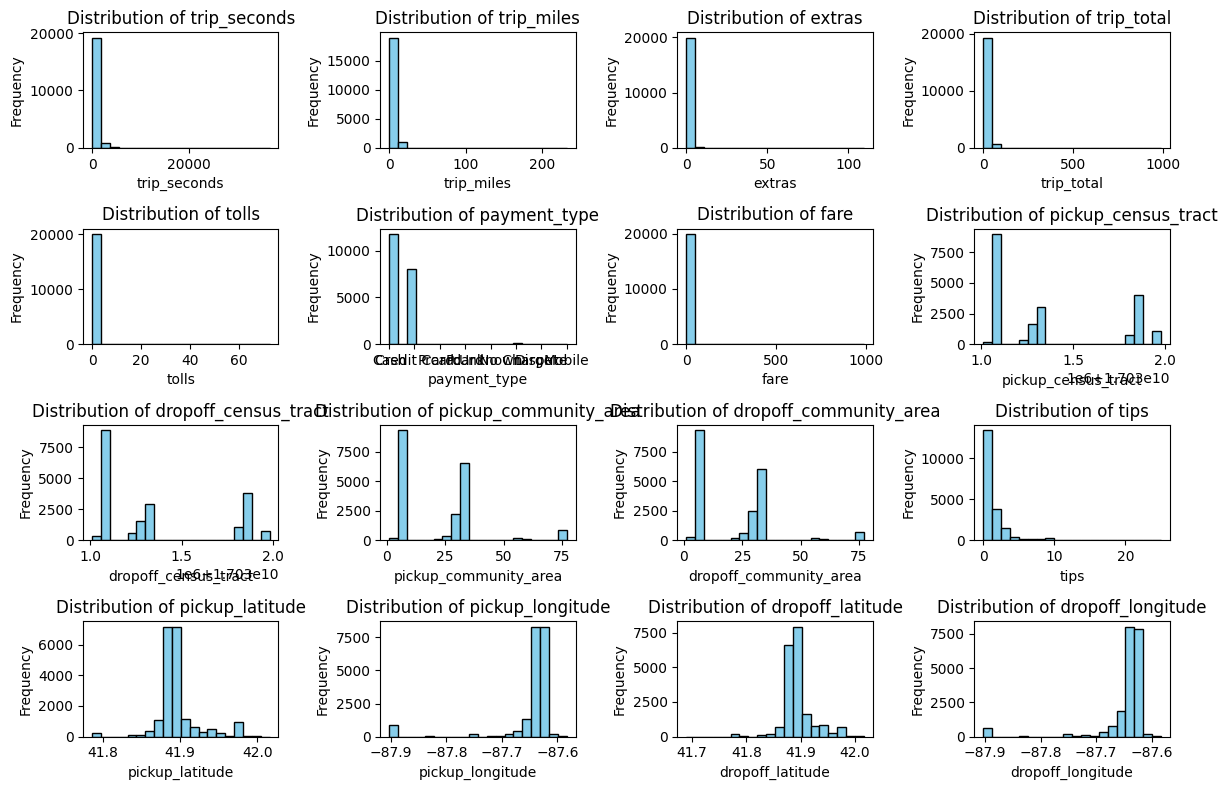

In [8]:
test_df = df
test_df.fillna(0, inplace=True)

features = ['trip_seconds', 
            'trip_miles', 
            "extras", 
            "trip_total", 
            "tolls", 
            "payment_type", 
            "fare",
            "pickup_census_tract", 
            "dropoff_census_tract", 
            "pickup_community_area",
            "dropoff_community_area",
            "tips",
            "pickup_latitude",
            "pickup_longitude",
            "dropoff_latitude",
            "dropoff_longitude",
           ]

num_features = len(features)
num_cols = 4
num_rows = (num_features - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, feature in enumerate(features):
    row_index = i // num_cols
    col_index = i % num_cols

    ax = axes[row_index, col_index] if num_rows > 1 else axes[col_index]

    ax.hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    row_index = i // num_cols
    col_index = i % num_cols
    fig.delaxes(axes[row_index, col_index])

plt.tight_layout()
plt.show()

In [9]:
# Correctly select the columns
df_int = df.loc[:, [
    'trip_seconds', 
    'trip_miles', 
    "extras", 
    "trip_total", 
    "tolls", 
    "payment_type", 
    "fare",
    "pickup_census_tract", 
    "dropoff_census_tract", 
    "pickup_community_area",
    "dropoff_community_area",
    "tips",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
]]

# Encode the 'payment_type' column
le = LabelEncoder()
df_int.loc[:, 'payment_type'] = le.fit_transform(df_int['payment_type'])
df_int['payment_type'] = df_int['payment_type'].astype(int)

# Display the first few rows of the DataFrame
df_int.head()


,trip_seconds,trip_miles,extras,trip_total,tolls,payment_type,fare,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,0,0.0,0.5,3.75,0.0,0,3.25,17031810400,17031760801,10,76,0.00,41.980507,-87.826676,41.982273,-87.841586
1,1320,2.9,0.0,17.00,0.0,1,13.50,17031071300,17031839100,7,32,3.00,41.921778,-87.641460,41.880994,-87.632746
2,0,0.0,0.0,27.25,0.0,0,27.25,17031810400,17031810400,10,10,0.00,41.980507,-87.826676,41.980507,-87.826676
3,0,0.0,0.0,34.69,0.0,1,27.25,17031810400,17031810400,10,10,6.94,41.980507,-87.826676,41.980507,-87.826676
4,2280,21.0,1.0,53.25,0.0,0,52.25,17031831400,17031491400,25,49,0.00,41.869119,-87.756068,41.689123,-87.616822


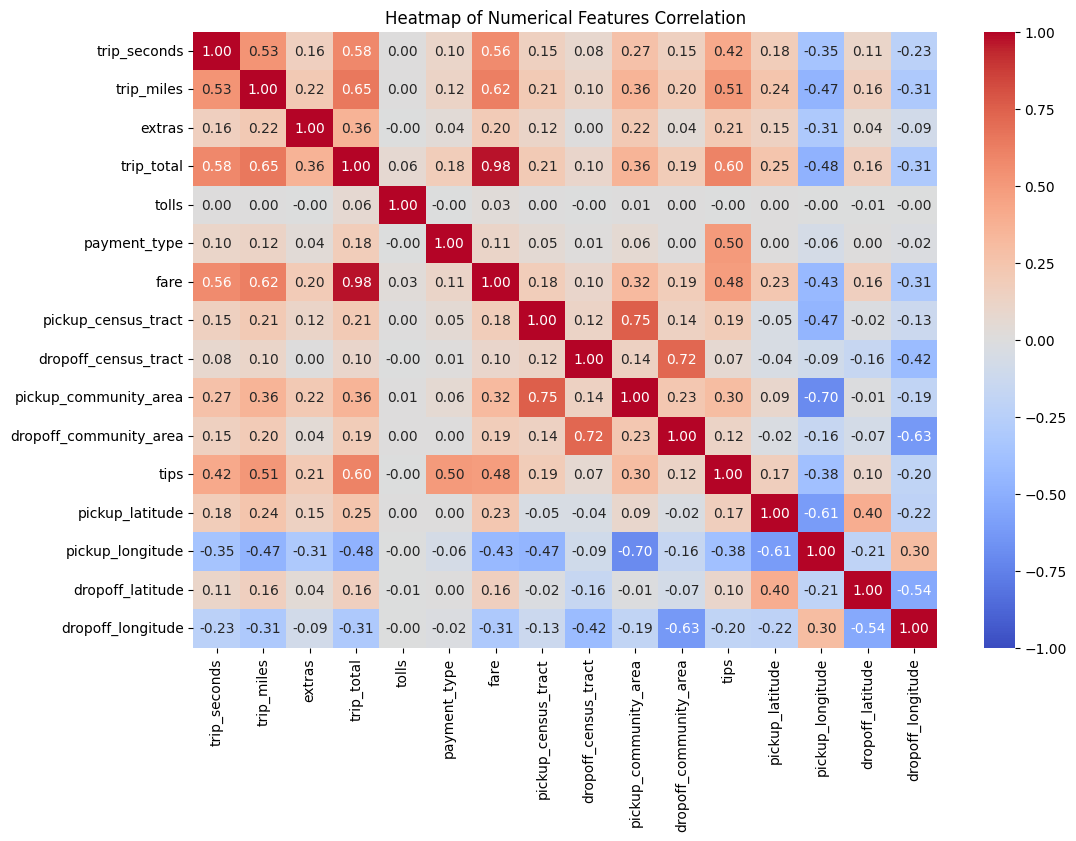

In [10]:
correlation_matrix = df_int.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt="0.2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Numerical Features Correlation')
plt.show()